# Image processing

This notebook process the raw image data into a binary image of size 128x128px.

<table>
    <tr>
        <td style="text-align: center;">Input</td>
        <td style="text-align: center;">Output</td>
    </tr>
    <tr>
        <td> <img src="./../data/shufadict/raw/总/05f54c9bc9307fa71449ab298cc2ac49.png" alt="input" style="height: 100px"> </td>
        <td> <img src="./../data/shufadict/tmp/clean_tmp/总/05f54c9bc9307fa71449ab298cc2ac49.png" alt="input" style="height: 100px"> </td>
    </tr>
</table>

**Prerequisite:**

The data are stored in the following format:
```
    raw_dir
    ├── 天
    │   ├── 02237bba94dff9b31e94b1ec0e5d6264.png
    │   ├── 039205b2e1d2a3a3c7686dda0b0eefe4.png
    │   ├── ...
    │   └── 10898d8e1ba407a4f37369eb080b9d2e.png
    ├── ...    
    └── 里
        ├── dfe190f491b488ff46b5753871959620.png
        ├── ee7722ff6e35ec5641cb59a50a40addf.png
        ├── ...
        └── fc4a676a2a60454a4714888c02b1bf0e.png
```

## Setup

In [1]:
%cd ..

import os
from tqdm.notebook import tqdm

import cv2 
import numpy as np 
from matplotlib import pyplot as plt
from modules.image_processing import segment_image, norm_char_size

%matplotlib inline

/Users/kx/Docs/github/git_chinese_calligraphy-recognition/chinese-calligraphy-recognition


In [2]:
# show a list of images
def show(imgs, col=5, titles=None, gray=True):
    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
        

# write image data to the given directory
# data is a dictionary with character as key and list of tuple (file_name, image_array)
# as values
def write_data(data, data_dir):
    for char in data.keys():
        char_path = os.path.join(data_dir, char)
        if not os.path.exists(char_path):
            os.mkdir(char_path)  
            
        for file, img in data[char]:
            
            fpath = os.path.join(data_dir, char, file)
            cv2.imwrite(fpath, img)
            

# read image data from the given directory
def read_data(data_dir):
    data = {}
    for char in [x for x in os.listdir(data_dir) if x != '.DS_Store']:
        data[char] = []
        char_path = os.path.join(data_dir, char) 
        for file in [x for x in os.listdir(char_path) if x != '.DS_Store']:
            fpath = os.path.join(data_dir, char, file)
            data[char].append((file, cv2.imread(fpath)))
    return data

In [3]:
# data directories
DIR_RAW = os.path.join('data', 'shufadict', 'raw')
DIR_CLEAN = os.path.join('data', 'shufadict', 'clean')
DIR_TMP = os.path.join('data', 'shufadict', 'tmp')

# character list
CHARS = [x for x in os.listdir(DIR_RAW) if x != '.DS_Store']

## Initial image processing
This step is fully automated, there might be segmentation fails or noises in the output, depending on the input image quality.

In [4]:
dir_input = DIR_RAW
dir_output = os.path.join(DIR_TMP, 'segmented')

In [6]:
raws = read_data(dir_input)
segmenteds = {}

for char in tqdm(CHARS):
    
    segmenteds[char] = []
    
    for file, image in raws[char]:
    
        # process image (blur and segment by kmeans)
        blur = cv2.GaussianBlur(image, (9, 9), 0)
        segmented = segment_image(blur)
        segmenteds[char].append((file, segmented))

# save images
write_data(segmenteds, dir_output)

  0%|          | 0/100 [00:00<?, ?it/s]

## Manual cleaning
Clean images with segmentation fails.

In [8]:
def remap_by_count(cc_img):
    retval = np.zeros(cc_img.shape)
    bincount = np.argsort(-np.bincount(cc_img.reshape(-1)))
    for i in range(bincount.shape[0]):
        retval[cc_img == bincount[i]] = i
    return retval

segmenteds = read_data(os.path.join(DIR_TMP, 'segmented'))
raws = read_data(DIR_RAW)

Step 1: Select character to process by char index

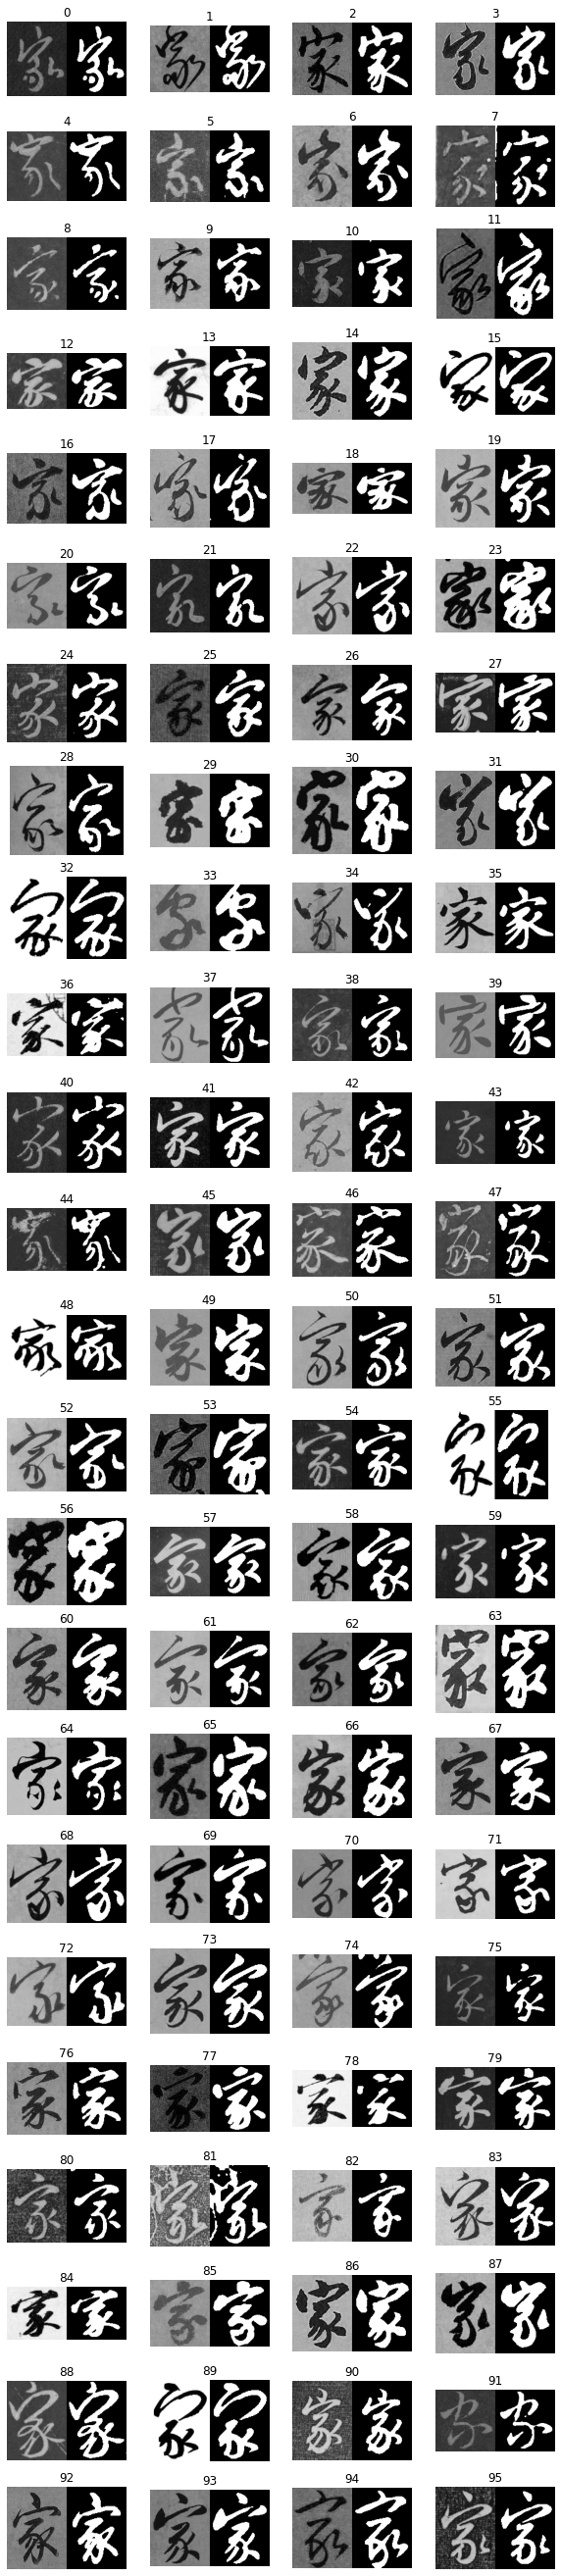

In [9]:
idx = 1

fnames = [x[0] for x in segmenteds[CHARS[idx]]] # file names
rimgs = [x[1] for x in raws[CHARS[idx]]] # raw images
simgs = [x[1][:, :, 0] for x in segmenteds[CHARS[idx]]] # segmented images
cimgs = [norm_char_size(x) for x in simgs] # cleaned images (output)
pending_idxs = [] # outliers index

concated = [np.concatenate((x[:, :, 0], y), axis = 1) for x, y in zip(rimgs, simgs)]
show(concated,  titles=[str(i) for i in range(len(rimgs))], col=4)

Step 2a: Select image to process by index, and select which connected components to keep (to remove noises)

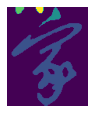

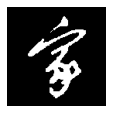

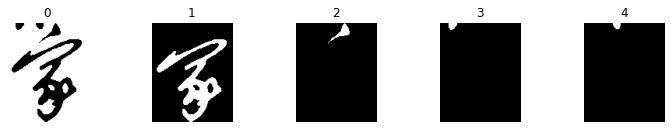

In [25]:
j = 74

# find connected components, reassign component label (larger region has smaller index)
num_labels, labels_im = cv2.connectedComponents((simgs[j] // 255).astype('uint8'))
labels_im = remap_by_count(labels_im)

# select components to keep
comps = list(range(1, num_labels - 2)) 
# comps = [1, 2, 3, 4]
cimgs[j] = norm_char_size(np.any([labels_im == x for x in comps], axis=0).astype(int) * 255)

show([labels_im], gray=False)
show([cimgs[j]])
show([labels_im == x for x in range(num_labels)], titles=[str(i) for i in range(num_labels)])

Step 2b: Playground (eg. crop image, modify blurring parameters)

In [ ]:
# blur = cv2.GaussianBlur(rimgs[j][:, :, :], (1, 1), 0)
# segmented = segment_image(blur)
# show([segmented])
# # simgs[j] = segmented

Step 2c: Add image index to `pending_idxs` if input image quality is too bad

In [12]:
pending_idxs.append(j)
pending_idxs

[81]

Step 3: Final validation

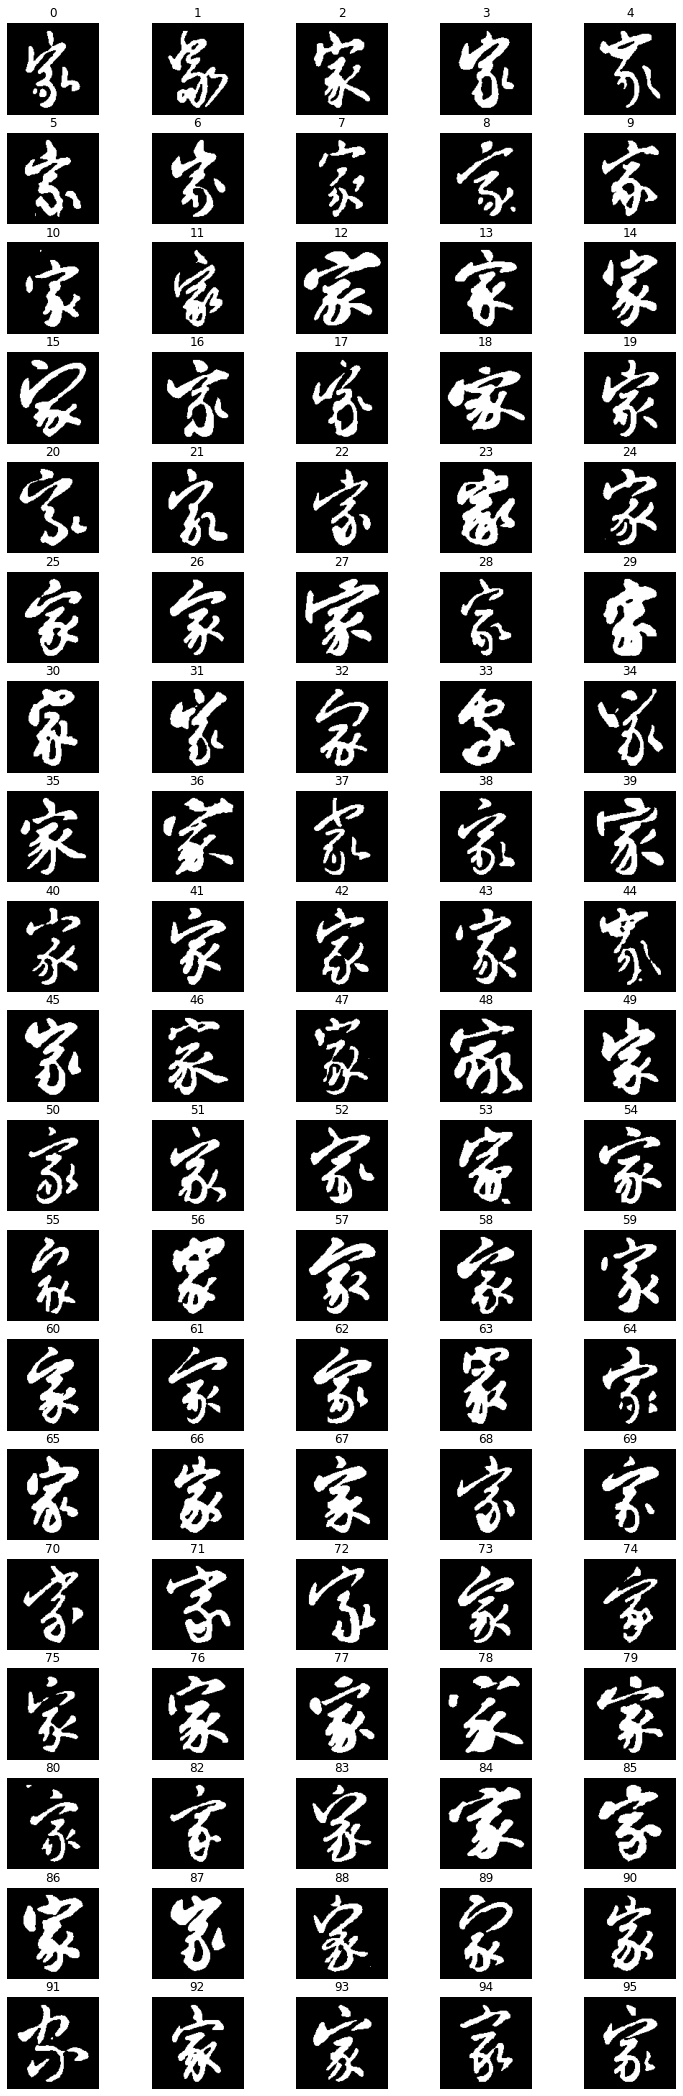

In [26]:
# cleaned images
show(
    [x for i, x in enumerate(cimgs) if i not in pending_idxs],  
    titles=[str(i) for i in range(len(rimgs)) if i not in pending_idxs]
)

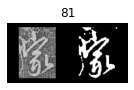

In [27]:
# failed images
concated = [np.concatenate((norm_char_size(x[:, :, 0]), y), axis = 1) for i, x, y in zip(range(len(rimgs)), rimgs, cimgs) if i in pending_idxs]
show(concated,  titles=[str(i) for i in pending_idxs])

Step 4: Write data, cleaned and failed images are written to separated directories

In [29]:
tmp = list(zip(fnames, cimgs))
data = { CHARS[idx]: [tmp[i] for i in range(len(tmp)) if i not in pending_idxs] }
write_data(data, os.path.join(DIR_TMP, 'clean_tmp'))

if len(pending_idxs) > 0:
    tmp = list(zip(fnames, rimgs))
    data = { CHARS[idx]: [tmp[i] for i in range(len(tmp)) if i in pending_idxs] }
    write_data(data, os.path.join(DIR_TMP, 'pending'))

### Process enhanced images from `pending`

In [28]:
dir_input = os.path.join(DIR_TMP, 'pending_enh')
dir_output = os.path.join(DIR_TMP, 'pending_clean')

In [30]:
raws = read_data(dir_input)
segmenteds = {}
cleaned = {}

for char in tqdm([x for x in os.listdir(dir_input) if x != '.DS_Store']):
    
    segmenteds[char] = []
    cleaned[char] = []
    
    for file, image in raws[char]:
    
        # process image (blur and segment by kmeans)
        blur = cv2.GaussianBlur(image, (9, 9), 0)
        segmented = segment_image(blur)
        segmenteds[char].append((file, segmented))
        cleaned[char].append((file, norm_char_size(segmented)))

# save images
write_data(cleaned, dir_output)

  0%|          | 0/64 [00:00<?, ?it/s]

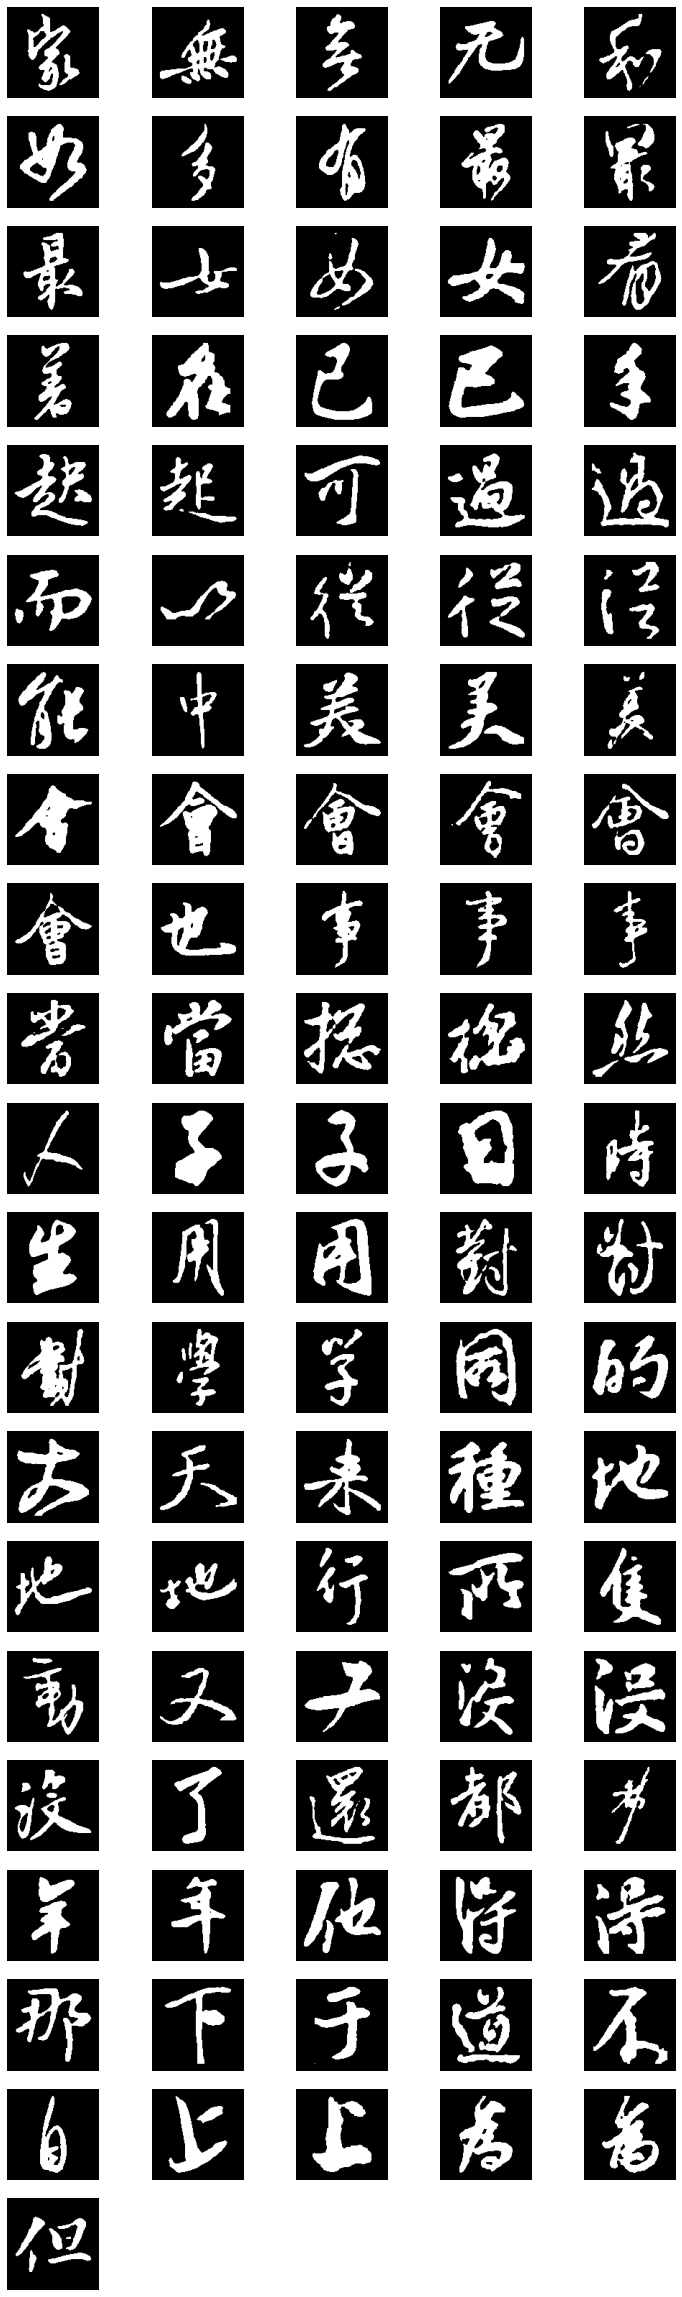

In [31]:
imgs = []
for char in cleaned:
    imgs += [img for file, img in cleaned[char]]
        
show(imgs)

In [ ]:
# cp -a data/tmp/pending_clean/. clean/
# cp -a data/tmp/clean_tmp/. clean/